<a href="https://colab.research.google.com/github/vanguardfox/ads509-group5/blob/main/Assignment_5_Topic_Modeling_GR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADS 509 Assignment 5.1: Topic Modeling

Name: Gabi Rivera \
Course: ADS509-01 \
Date: 06Oct2024 \

>

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories.


In [26]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [27]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [28]:
# add any additional libaries you need here
import nltk
nltk.download('brown')
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [30]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [31]:
# Define the categories
categories = ['editorial', 'government', 'news', 'romance', 'hobbies']

# Initialize lists to store data
category_list = []
file_ids = []
texts = []

# Loop through each category and file
for category in categories:
    for file_id in brown.fileids(categories=category):
        # Append category, file ID, and text to the lists
        category_list.append(category)
        file_ids.append(file_id)

        # Get the text of the article and join words into a single string
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

# Create the DataFrame
df = pd.DataFrame({
    'category': category_list,
    'id': file_ids,
    'text': texts
})

# Show the shape of the DataFrame
df_shape = df.shape
print(f"The DataFrame has {df_shape[0]} rows and {df_shape[1]} columns.")

The DataFrame has 166 rows and 3 columns.


In [32]:
# Calculate character length and word count
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

# Display the updated DataFrame shape and the first few rows for verification
print(f"The DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
print(df.head())

The DataFrame has 166 rows and 5 columns.
    category    id                                               text  \
0  editorial  cb01  Assembly session brought much good The General...   
1  editorial  cb02  Must Berlin remain divided ? ? The inference h...   
2  editorial  cb03  A good man departs . Goodby , Mr. Sam . Sam Ra...   
3  editorial  cb04  A shock wave from Africa Word of Dag Hammarskj...   
4  editorial  cb05  Help when needed If the Dominican Republic ach...   

   char_len  word_len  
0     12659      2200  
1     12544      2234  
2     11871      2244  
3     12284      2230  
4     12479      2241  


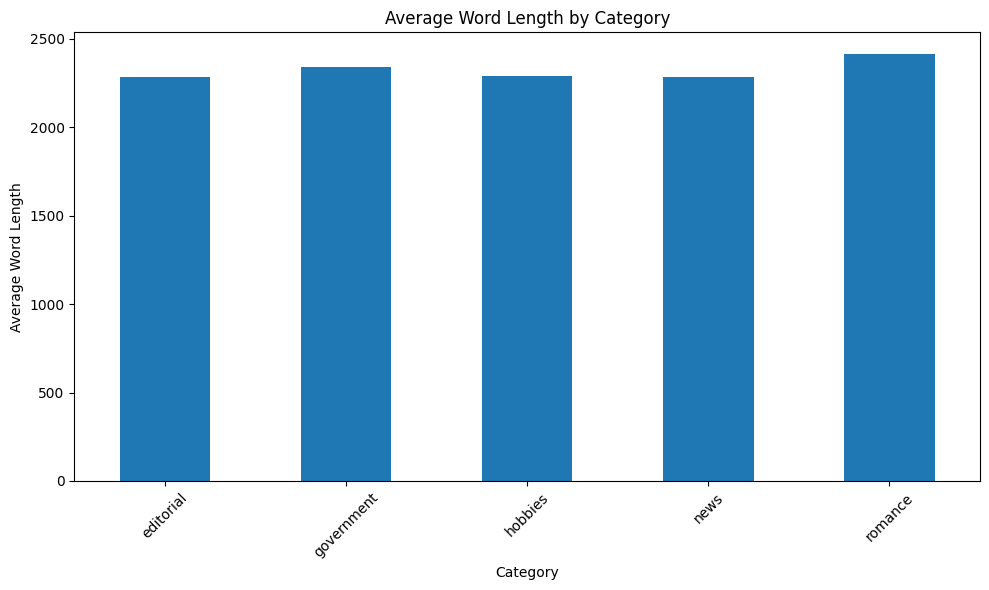

In [33]:
# Set up inline plotting
%matplotlib inline

# Group by category and calculate the mean word length
mean_word_length = df.groupby('category').agg({'word_len': 'mean'})

# Create a bar plot
mean_word_length.plot.bar(figsize=(10, 6), legend=False)
plt.title('Average Word Length by Category')
plt.xlabel('Category')
plt.ylabel('Average Word Length')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now do our TF-IDF and Count vectorizations.

In [34]:
# Define stopwords
stop_words = stopwords.words('english')

# Create the Count Vectorizer
count_text_vectorizer = CountVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)

# Fit and transform the text data
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])

# Check the shape of the resulting matrix
print(f"Count Vectorization shape: {count_text_vectors.shape}")

Count Vectorization shape: (166, 5073)


In [35]:
# Create the TF-IDF Vectorizer
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)

# Fit and transform the text data
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])

# Check the shape of the resulting matrix
print(f"TF-IDF Vectorization shape: {tfidf_text_vectors.shape}")

TF-IDF Vectorization shape: (166, 5073)


Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold?

A: The shape both holds the same (number of documents, unique terms). But for count vectorization, measures the raw frequency of the term. While, TF-IDF adjust the frequencies based on importance across the corpus. It essentially reduces the weight of commonly occurring terms and increases the weight of rare terms.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections.

In [36]:
# Fit the NMF model with 5 topics
nmf_text_model = NMF(n_components=5, random_state=314)

# Transform the TF-IDF vectors into the W (document-topic) matrix
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)

# Get the H (topic-term) matrix
H_text_matrix = nmf_text_model.components_

# Output the shapes of the resulting matrices
print(f"W (document-topic) matrix shape: {W_text_matrix.shape}")
print(f"H (topic-term) matrix shape: {H_text_matrix.shape}")

W (document-topic) matrix shape: (166, 5)
H (topic-term) matrix shape: (5, 5073)


In [37]:
# Call the function to display topics
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.48)
  president (0.43)
  kennedy (0.41)
  united (0.40)
  khrushchev (0.38)

Topic 01
  said (0.78)
  thought (0.38)
  back (0.34)
  man (0.34)
  little (0.31)

Topic 02
  mrs (2.38)
  mr (0.75)
  said (0.71)
  miss (0.48)
  car (0.46)

Topic 03
  state (0.38)
  development (0.35)
  tax (0.32)
  sales (0.29)
  may (0.28)

Topic 04
  game (0.97)
  league (0.70)
  ball (0.69)
  baseball (0.66)
  team (0.63)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results.


In [38]:
# Get the dominant topic for each document
document_topics = np.argmax(W_text_matrix, axis=1)

# Create a DataFrame to tally categories per topic
topic_category_tally = pd.DataFrame(0, index=range(5), columns=categories)

# Tally the original categories for each topic
for doc_idx, topic in enumerate(document_topics):
    category = df['category'].iloc[doc_idx]
    topic_category_tally.loc[topic, category] += 1

# Display the tally
print("Tally of Brown Categories per NMF Topic:")
print(topic_category_tally)

Tally of Brown Categories per NMF Topic:
   editorial  government  news  romance  hobbies
0         21           5     8        0        1
1          5           0     0       29       10
2          0           0    18        0        1
3          1          25     9        0       22
4          0           0     9        0        2


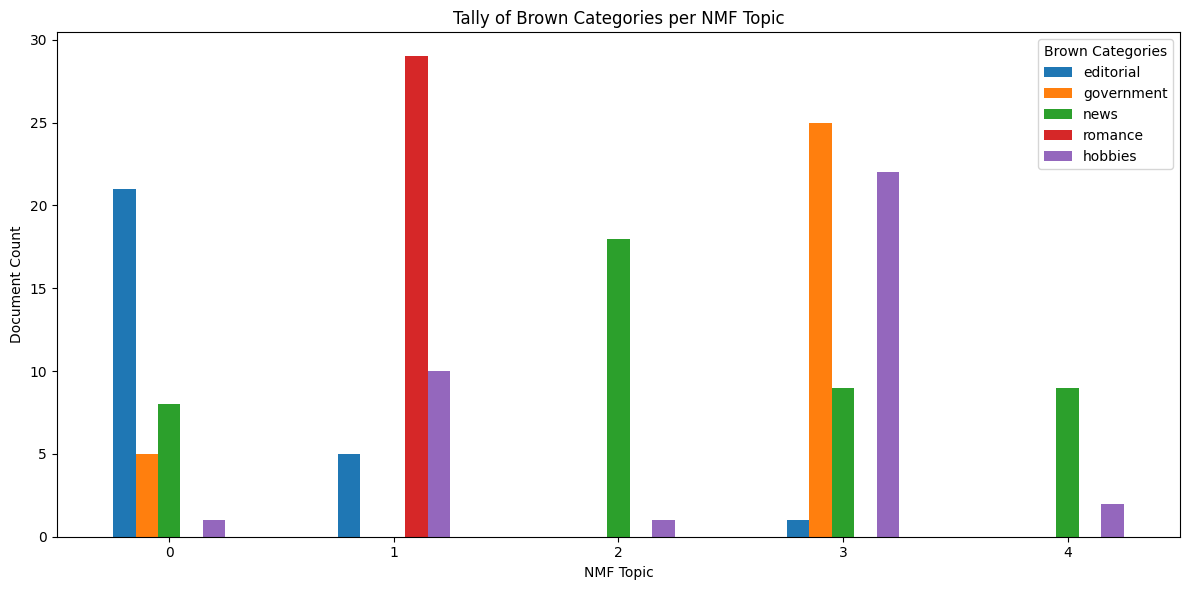

In [39]:
# Plotting the tally
topic_category_tally.plot(kind='bar', figsize=(12, 6))
plt.title('Tally of Brown Categories per NMF Topic')
plt.xlabel('NMF Topic')
plt.ylabel('Document Count')
plt.xticks(rotation=0)
plt.legend(title='Brown Categories')
plt.tight_layout()
plt.show()

Q: How does your five-topic NMF model compare to the original Brown categories?

A: There are clear categories associated to each topics. This suggest that the NMF model fairly captures the structure of the original brown categories. Although, hobbies did not top any topic. It might just mean that it's overlapping on Topic 3 with government terms.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above.

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results.


In [40]:
# Fit the LSA model with 5 topics
lsa_model = TruncatedSVD(n_components=5, random_state=314)
lsa_topic_matrix = lsa_model.fit_transform(tfidf_text_vectors)

# Get the components (topics)
lsa_components = lsa_model.components_

# Output the shapes of the resulting matrices
print(f"LSA Topic Matrix shape: {lsa_topic_matrix.shape}")
print(f"LSA Components shape: {lsa_components.shape}")

LSA Topic Matrix shape: (166, 5)
LSA Components shape: (5, 5073)


In [41]:
# Get the dominant topic for each document
document_topics_lsa = np.argmax(lsa_topic_matrix, axis=1)

# Create a DataFrame to tally categories per LSA topic
lsa_topic_category_tally = pd.DataFrame(0, index=range(5), columns=categories)

# Tally the original categories for each topic
for doc_idx, topic in enumerate(document_topics_lsa):
    category = df['category'].iloc[doc_idx]
    lsa_topic_category_tally.loc[topic, category] += 1

# Display the tally
print("Tally of Brown Categories per LSA Topic:")
print(lsa_topic_category_tally)

Tally of Brown Categories per LSA Topic:
   editorial  government  news  romance  hobbies
0         27          30    34       25       36
1          0           0     0        4        0
2          0           0     3        0        0
3          0           0     0        0        0
4          0           0     7        0        0


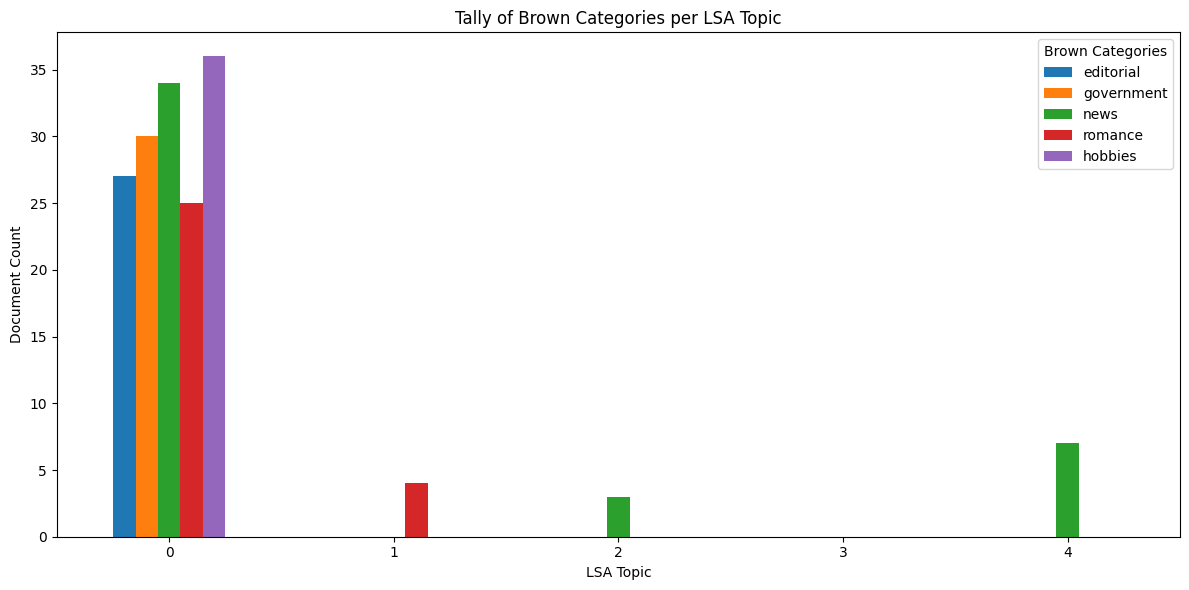

In [42]:
# Plotting the tally for LSA
lsa_topic_category_tally.plot(kind='bar', figsize=(12, 6))
plt.title('Tally of Brown Categories per LSA Topic')
plt.xlabel('LSA Topic')
plt.ylabel('Document Count')
plt.xticks(rotation=0)
plt.legend(title='Brown Categories')
plt.tight_layout()
plt.show()

Q: How does your five-topic LSA model compare to the original Brown categories?

A: The first topic captures a broad range of categories and the rest of the topics are less defined, maybe more specilized or niche. Compared to NMF model, LSA performed poorly in isolating specific topics across the given categories.

In [43]:
# Call the function to display topics
display_topics(lsa_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.41)
  mr (0.23)
  mrs (0.20)
  state (0.19)
  man (0.16)

Topic 01
  said (3.71)
  thought (2.13)
  back (1.90)
  got (1.90)
  looked (1.76)

Topic 02
  mrs (4.51)
  mr (1.91)
  said (1.47)
  jr (0.88)
  jury (0.85)

Topic 03
  mrs (5.14)
  game (1.98)
  club (1.50)
  dallas (1.50)
  league (1.44)

Topic 04
  game (4.95)
  league (3.55)
  baseball (3.47)
  ball (3.36)
  team (3.18)


Q: What is your interpretation of the display topics output?

A: Comparing from NMF model, it does seem that the topics where the words are the most similar between the two models have the same hits for the categories. The most different are Topic 0 and Topic 3. Topic 0 have captured a broad range of categories being hobbies as the highest. Topic 3 did not result to any hits across the categories. Maybe the words are too game centered which makes me think that maybe it should have captured hobbies as well.  

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization.

In [44]:
# Fit the LDA model with 5 topics
lda_model = LatentDirichletAllocation(n_components=5, random_state=314)
lda_topic_matrix = lda_model.fit_transform(count_text_vectors)

# Output the shape of the resulting matrix
print(f"LDA Topic Matrix shape: {lda_topic_matrix.shape}")

LDA Topic Matrix shape: (166, 5)


In [45]:
# Call the display_topics function to show LDA topics
display_topics(lda_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  game (0.52)
  last (0.51)
  home (0.50)
  clay (0.49)
  three (0.43)

Topic 01
  may (0.81)
  service (0.67)
  medical (0.62)
  national (0.51)
  use (0.51)

Topic 02
  much (0.46)
  good (0.46)
  way (0.41)
  used (0.39)
  must (0.32)

Topic 03
  state (0.98)
  states (0.67)
  united (0.62)
  government (0.55)
  may (0.49)

Topic 04
  said (1.88)
  mrs (0.87)
  man (0.51)
  back (0.48)
  mr (0.48)


In [46]:
# Get the dominant topic for each document
document_topics_lda = np.argmax(lda_topic_matrix, axis=1)

# Create a DataFrame to tally categories per LDA topic
lda_topic_category_tally = pd.DataFrame(0, index=range(5), columns=categories)

# Tally the original categories for each topic
for doc_idx, topic in enumerate(document_topics_lda):
    category = df['category'].iloc[doc_idx]
    lda_topic_category_tally.loc[topic, category] += 1

# Display the tally
print("Tally of Brown Categories per LDA Topic:")
print(lda_topic_category_tally)

Tally of Brown Categories per LDA Topic:
   editorial  government  news  romance  hobbies
0          0           0     7        0        6
1          1           5     1        0        5
2          4           2     0        7       19
3         18          23    19        0        1
4          4           0    17       22        5


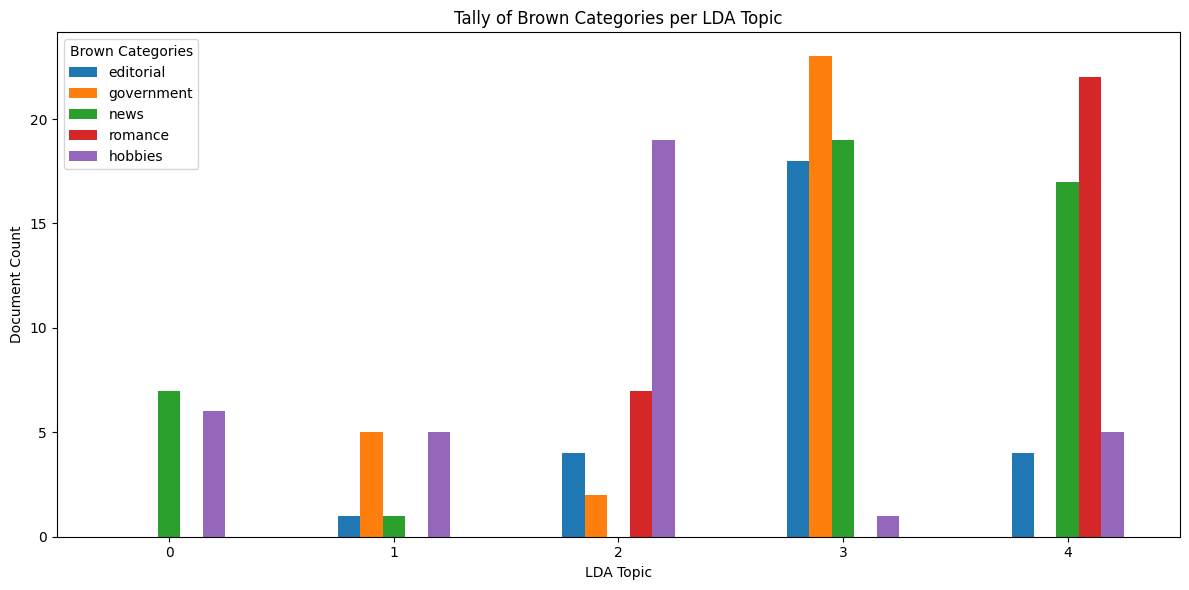

In [47]:
# Plotting the tally for LDA
lda_topic_category_tally.plot(kind='bar', figsize=(12, 6))
plt.title('Tally of Brown Categories per LDA Topic')
plt.xlabel('LDA Topic')
plt.ylabel('Document Count')
plt.xticks(rotation=0)
plt.legend(title='Brown Categories')
plt.tight_layout()
plt.show()

Q: What inference do you draw from the displayed topics for your LDA model?

A: Topic 0 has terms that relates to games. Topic 1 has terms that relates to government, maybe news. Topic 2 has terms that are filler or neutral words. Topic 3 has terms that relates to government, maybe news. Topic 4 has term that pertains to gender.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories?

A: LDA model performed better than LSA. The model was able to capture category hits across the topics fairly well. It has more topics that captures broader range of categories compared to NMF model. If we look at the highest category for each topics and refer to the topic's list of term, it does seem that the highest hits are reasonable related.

In [52]:
# Prepare the visualization
lda_display = pyLDAvis.lda_model.prepare(lda_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [53]:
# Display the visualization
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: The priciple component cirlces are well separated which means that LDA model was able to identify the categories within the corpus effectively. If we look at the size, Topic 4 (or Topic 3 from Brown plot) is the largest followed by Topic 5 (Topic 4 from Brown plot). Their size indicates that they're more prevelent across the categories. We can also visualize this when we look over to the top 30 list, which shows the frequency of the top representative terms. Topic 4 and Topic 5 have the longest reds bars against the overall frequency in blue. This tells us that the PC circle size for each topic corresponds to the proportion of the representative terms in the corpus.
